In [92]:
%matplotlib inline # required if you want plots to be visible within the notebook

In [1]:
# imports
import torch
from torch import nn

import torchvision
from torchvision import transforms

from matplotlib import pyplot as plt

**Train and test dataset**

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor()
    ]) # transform the images to format which our network can process


# download (into .data folder) and load the train/test CIFAR10 dataset
train_ds = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=4,
                                          shuffle=True, num_workers=2)

test_ds = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=4,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


**Explore the train dataset**

In [3]:
for batch in train_dl:
    break

In [4]:
x,y=batch
x.shape, y.shape

(torch.Size([4, 3, 32, 32]), torch.Size([4]))

In [5]:
y

tensor([3, 4, 3, 4])

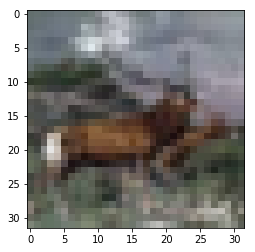

In [6]:
img=x[1].transpose(0,1).transpose(1,2) # need to make channels the last dimension
plt.imshow(img)

**Model**

In [7]:
# net architecture
class FCNet(nn.Module): # should inherit the model from nn.Module (parent class)
    def __init__(self, in_dim, n_classes):
        super(FCNet, self).__init__() # calls the constructor (__init__) of parent class
        self.in_dim=in_dim
        self.n_classes=n_classes
        # 3 layers
        self.l1=nn.Linear(self.in_dim, 1000)
        self.l2=nn.Linear(1000, 300)
        self.l3=nn.Linear(300, self.n_classes)
        self.relu=nn.ReLU()
    
    def forward(self, x): # forward pass
        B,C,H,W=x.shape
        x=x.view(B, C*H*W) # flatten each 3x32x32 image to vector of size 3*32*32
        #print(x.shape) # shoudl be size (B,C*H*W)
        
        x2=self.relu(self.l1(x)) # linear followed by ReLU activation
        x3=self.relu(self.l2(x2))
        x4=self.l3(x3)
        return x4     

In [8]:
net=FCNet(in_dim=32*32*3, n_classes=10) # instantiate the net object

In [9]:
res=net(x) # test the network on the batch we used for visualization earlier
res.shape

torch.Size([4, 10])

In [10]:
loss_func=nn.CrossEntropyLoss() # cross-entropy loss function

In [11]:
# explore the weights in net.parameters()
for wt in net.parameters():
    print(wt.shape)

torch.Size([1000, 3072])
torch.Size([1000])
torch.Size([300, 1000])
torch.Size([300])
torch.Size([10, 300])
torch.Size([10])


In [12]:
optimizer=torch.optim.SGD(net.parameters(), lr=0.001) # contruct the optimizer with learning rate=0.001

**Train/Eval loop**

In [13]:
def train(n_epochs): # train loop
    """
        train loop
        * Here we defined dataloaders, net etc. as global variables, which is a bad practice. In the interest of time, we did this for the discussion
    """
    train_loss=[]
    test_loss=[]
    for ep in range(n_epochs):
        tr_loss=0.
        net.train() # set the model in train mode
        for x,y in train_dl:
            yp=net(x)
            loss=loss_func(yp, y)
            optimizer.zero_grad() # need to clear the gradients from previous batch
            loss.backward() # compute the gradients
            optimizer.step() # update the weights/parameters
            tr_loss+=loss.item() 
        tr_loss=tr_loss/len(train_ds) # avg train loss
        torch.save(net.state_dict(), f"epoch{ep}.pt") # save the model (model state more specifically) at end of each epoch
        
        train_loss.append(tr_loss)
        te_loss=0.
        net.eval() # set the model in evaluation mode
        for x,y in test_dl: # dont need to do gradient calculation and weight update
            yp=net(x)
            loss=loss_func(yp, y)
            te_loss+=loss.item() 
        te_loss=te_loss/len(test_ds) # avg test loss
        test_loss.append(te_loss) 
        print(f"Epoch : {ep}, Train loss: {tr_loss}, Valid/Test loss: {te_loss}")
    return train_loss, test_loss

In [14]:
train_loss,test_loss=train(10) # train for 10 epochs
# this will take some time if you are training on a CPU

Epoch : 0, Train loss: 0.5078143678843975, Valid/Test loss: 0.4691374388217926
Epoch : 1, Train loss: 0.45467059821009637, Valid/Test loss: 0.4421157549500465
Epoch : 2, Train loss: 0.4301031427705288, Valid/Test loss: 0.41791236040592195
Epoch : 3, Train loss: 0.4124483621865511, Valid/Test loss: 0.4072909691333771
Epoch : 4, Train loss: 0.39854036546587945, Valid/Test loss: 0.3890887553811073
Epoch : 5, Train loss: 0.3870268115115166, Valid/Test loss: 0.3850702167928219
Epoch : 6, Train loss: 0.3771625420212746, Valid/Test loss: 0.3747491391003132
Epoch : 7, Train loss: 0.3689469957327843, Valid/Test loss: 0.3734617879807949
Epoch : 8, Train loss: 0.36163751061677935, Valid/Test loss: 0.3654598534941673
Epoch : 9, Train loss: 0.35447882014214993, Valid/Test loss: 0.3560542758256197


**Plot the losses**

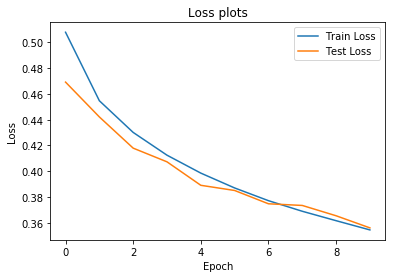

In [21]:
ax=plt.gca()
ax.plot(train_loss, label="Train Loss") #use ax.plot instead of plt.plot to display both train and valid loss in the same plot
ax.plot(test_loss, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss plots")
plt.legend()
plt.show()

**Loading saved model weights**

In [15]:
# typically this happens in a different file after we have trained the model, so we create a new instance of model (eval_net)
eval_net=FCNet(in_dim=32*32*3, n_classes=10) # model initialized with random values for weights
wt_path="epoch7.pt"
state_dict=torch.load(wt_path) # load saved weights
eval_net.load_state_dict(state_dict) # load the saved weights into this model

IncompatibleKeys(missing_keys=[], unexpected_keys=[])